# Exploration 19.  Conditional Generative Model ( cGAN )
## 조건 있는 생성 모델
일반적인 GAN과 같은 unconditioned generative model은 내가 생성하고자 하는 데이터에 대해 제어하기 힘들다.  

__Conditional Generative Adversarial Nets (cGAN)__ 은 원하는 종류의 이미지를 생성하고자 할 때 GAN이 가진 생성 과정의 불편함을 해소하여, 원하는 종류의 이미지를 생성할 수 있도록 고안된 방법이다.

### GAN 학습과정
![image](https://user-images.githubusercontent.com/84179578/134269218-b6e58e11-517d-474a-a10d-eaea5b477246.png)

- Generator
  - 노이즈 zz(파란색)가 입력되고 특정 representation(검정색)으로 변환된 후 가짜 데이터 G(z)G(z) (빨간색)를 생성해낸다.
- Discriminator
  - 실제 데이터 xx와 Generator가 생성한 가짜 데이터 G(z)G(z)를 각각 입력받아 D(x)D(x) 및 D(G(z))D(G(z)) (보라색)를 계산하여 진짜와 가짜를 식별해낸다.

### cGAN 학습과정

![image](https://user-images.githubusercontent.com/84179578/134269445-ab454ffa-40c5-47d6-bff8-0dcc080a5f24.png)

- Generator
  - 노이즈 z(파란색)와 추가 정보 y(녹색)을 함께 입력받아 Generator 내부에서 결합되어 representation(검정색)으로 변환되며 가짜 데이터 G(z∣y)G(z∣y)를 생성한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 y는 레이블 정보이며, 일반적으로 one-hot 벡터를 입력으로 넣는다.
- Discriminator
  - 실제 데이터 x와 Generator가 생성한 가짜 데이터 G(z∣y)G(z∣y)를 각각 입력받으며, 마찬가지로 yy정보가 각각 함께 입력되어 진짜와 가짜를 식별한다. MNIST나 CIFAR-10 등의 데이터셋에 대해 학습시키는 경우 실제 데이터 x와 y는 알맞은 한 쌍("7"이라 쓰인 이미지의 경우 레이블도 7)을 이뤄야 하며, 마찬가지로 Generator에 입력된 yy와 Discriminator에 입력되는 y는 동일한 레이블을 나타내야한다.

 GAN과 cGAN을 각각 간단하게 구현하고 실험해보자.

----
# 내가 원하는 숫자 이미지 만들기
## 1. 데이터 준비
tensorflow-dataset 라이브러리를 통해 MNIST 데이터셋을 불러온다.
```
$ pip install tensorflow-dataset
```

Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /aiffel/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


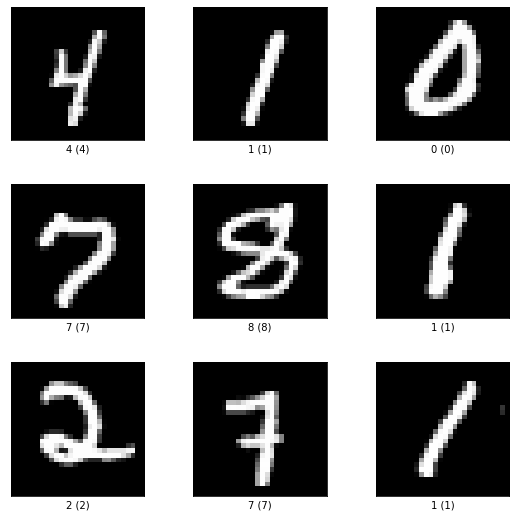

In [1]:
import tensorflow_datasets as tfds

mnist, info =  tfds.load(
    "mnist", split="train", with_info=True
)

fig = tfds.show_examples(mnist, info)

여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었다. 

## 2. 데이터 전처리

학습 전에 필요한 몇가지 처리를 수행하는 함수를 정의한다.  
- 이미지 픽셀 값을 -1~1 사이의 범위로 변경
- 레이블 정보를 원-핫 인코딩(one-hot encoding)

GAN 과 cGAN 을 각각 실험하기 위해서 label 정보 사용 유무에 따라 `gan_preprocessing()` 과 `cgan_preprocessing()`  두가지 함수를 정의한다.

In [2]:
import tensorflow as tf

BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

한 개의 데이터셋만 불러와 원하는대로 정확히 처리되었는지 확인한다.

Label : tf.Tensor([0. 0. 0. 0. 0. 0. 1. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min/Max : -1.0 1.0


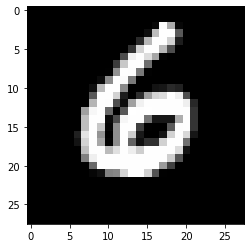

In [3]:
import matplotlib.pyplot as plt

for i,j in cgan_datasets : break

# 이미지 i와 라벨 j가 일치하는지 확인해 봅니다.     
print("Label :", j[0])
print("Image Min/Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0,...,0], plt.cm.gray)

## 3. GAN Generator 구성
구현은 Tensorflow2의 Subclassing 방법을 이용한다.  

Subclassing 방법은 `tensorflow.keras.Model` 을 상속받아 클래스를 만들며, 일반적으로 `__init__()` 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 `call()` 메서드에서 사용해 forward propagation을 진행한다. 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있다.  

먼저 GAN의 Generator를 아래와 같이 구현한다.

In [4]:
from tensorflow.keras import layers, Input, Model

class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()

        self.dense_1 = layers.Dense(128, activation='relu')
        self.dense_2 = layers.Dense(256, activation='relu')
        self.dense_3 = layers.Dense(512, activation='relu')
        self.dense_4 = layers.Dense(28*28*1, activation='tanh')

        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

- `__init__()` 메서드 안에서 사용할 모든 레이어를 정의했다. 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용한다.
- `call()` 메서드에서는 노이즈를 입력받아 `__init__()`에서 정의된 레이어들을 순서대로 통과한다.
- Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 `layers.Reshape()`을 이용해 `(28,28,1)` 크기로 변환된다.

## 4. cGAN Generator 구성 

In [5]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z = layers.Dense(256, activation='relu')
        self.dense_y = layers.Dense(256, activation='relu')
        self.combined_dense = layers.Dense(512, activation='relu')
        self.final_dense = layers.Dense(28 * 28 * 1, activation='tanh')
        self.reshape = layers.Reshape((28, 28, 1))

    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out = self.combined_dense(tf.concat([noise, label], axis=-1))
        out = self.final_dense(out)
        return self.reshape(out)

GAN의 Generator보다 구현이 복잡한듯 하지만 ,이전에 cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐이다.  

- 노이즈 입력 및 레이블 입력은 각각 1개의 fully-connected 레이어와 ReLU 활성화를 통과한다. (`dense_z`, `dense_y`)
- 위의 각 결과가 서로 연결되어 다시 한번 1개의 fully-connected 레이어와 ReLU 활성화를 통과한다 (`tf.concat, conbined_dense`)
- 위의 결과가 1개의 fully-connected 레이어 및 Hyperbolic tangent 활성화를 거쳐 28x28 차원의 결과가 생성되고 `(28,28,1)` 크기의 이미지 형태로 변환되어 출력된다 (final_dense, reshape)

## 5. GAN Discriminator 구성

실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해보자.

In [6]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(
                layers.Dense(f, activation=None if f==1 else "relu")
            )
        
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

- `__init__()` 에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 차곡차곡 쌓아놓았다. 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다.
- Discriminator의 입력은 Generator가 생성한 `(28,28,1)` 크기의 이미지이며, 이를 fully-connected 레이어로 학습하기 위해 `call()`에서는 가장 먼저 `layers.Flatten()`이 적용된다.
- 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킨다.
- 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

## 6. cGAN Discriminator 구성
cGAN의 Discriminator는 `Maxout`이라는 특별한 레이어가 사용된다.  

`Maxout`은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다.  
만약 2개의 fully-connected 레이어를 사용할 때 `Maxout`을 식으로 표현하면 아래와 같다.  

$$
\max \left(w_{1}^{T} x+b_{1}, w_{2}^{T} x+b_{2}\right)
$$

아래와 같이 `Maxout` 을 구성할 수 있다.

In [7]:
class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense = layers.Dense(units*pieces, activation="relu")
        self.dropout = layers.Dropout(.5)    
        self.reshape = layers.Reshape((-1, pieces, units))
    
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis=1)

Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력한다.  
예를 들어, 사용할 `Maxout` 레이어가 `units=100`, `pieces=10`으로 설정 된다면 입력으로 부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력된다. 식으로 나타낸다면 아래와 같다. (위 예시에서는 각각의 `wx+b`가 모두 100차원)  


$$
\max \left(w_{1}^{T} x+b_{1}, w_{2}^{T} x+b_{2}, \ldots, w_{9}^{T} x+b_{9}, w_{10}^{T} x+b_{10}\right)
$$

Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있다.

In [8]:
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block = Maxout(240, 5)
        self.label_block = Maxout(50, 5)
        self.combine_block = Maxout(240, 4)
        
        self.dense = layers.Dense(1, activation=None)
    
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x = layers.Concatenate()([image, label])
        x = self.combine_block(x)
        return self.dense(x)

- GAN의 Discriminator와 마찬가지로 Generator가 생성한 `(28,28,1)` 크기의 이미지가 입력되므로, `layers.Flatten()`이 적용된다.  
- 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 `Maxout` 레이어를 한번 더 통과한다.  
- 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

## 7. GAN으로 MNIST 학습 및 테스트

Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해보자.  

우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의한다. 진짜 및 가짜를 구별하기 위해 `Binary Cross Entropy`를 사용하고, `Adam optimizer`를 이용해 학습한다.

In [9]:
from tensorflow.keras import optimizers, losses

bce = losses.BinaryCrossentropy(from_logits=True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)    

이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용한다.  
여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 정의한다.

In [10]:
gan_generator = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        # Discriminator를 이용해 진짜 및 가짜이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    return gene_loss, disc_loss

위 함수를 이용해 우선 10 epoch만큼 학습을 진행한다. 100번의 반복마다 각 손실(loss)을 출력한다.

In [11]:
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)

        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i+1} ITER] G:{gene_loss}, D:{disc_loss}")

[1/10 EPOCHS, 100 ITER] G:1.9696707725524902, D:0.18356341123580933
[1/10 EPOCHS, 200 ITER] G:2.7556204795837402, D:0.08979523181915283
[1/10 EPOCHS, 300 ITER] G:2.6053009033203125, D:0.11996389180421829
[1/10 EPOCHS, 400 ITER] G:2.2647595405578613, D:0.1470157355070114
[2/10 EPOCHS, 100 ITER] G:1.921525478363037, D:0.37482744455337524
[2/10 EPOCHS, 200 ITER] G:3.841576099395752, D:0.2316238284111023
[2/10 EPOCHS, 300 ITER] G:3.1372885704040527, D:0.13008789718151093
[2/10 EPOCHS, 400 ITER] G:3.132829427719116, D:0.11272451281547546
[3/10 EPOCHS, 100 ITER] G:3.089139461517334, D:0.11220090091228485
[3/10 EPOCHS, 200 ITER] G:4.114435195922852, D:0.04268302768468857
[3/10 EPOCHS, 300 ITER] G:3.551236867904663, D:0.07745768129825592
[3/10 EPOCHS, 400 ITER] G:4.1880669593811035, D:0.05271689593791962
[4/10 EPOCHS, 100 ITER] G:3.6893234252929688, D:0.09193858504295349
[4/10 EPOCHS, 200 ITER] G:5.398830413818359, D:0.05023930221796036
[4/10 EPOCHS, 300 ITER] G:5.213912010192871, D:0.05971932

학습된 모델을 테스트해보자. 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화한다.

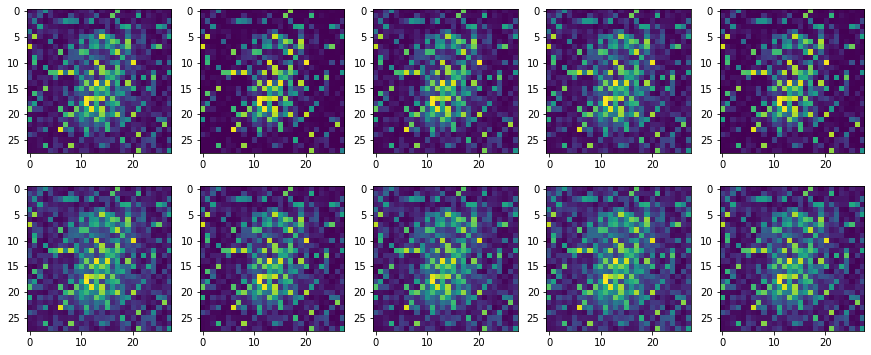

In [12]:
import numpy as np

noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없나보다.  
위 구현을 그대로 500 epoch 학습한 가중치를 한번 사용해보자.

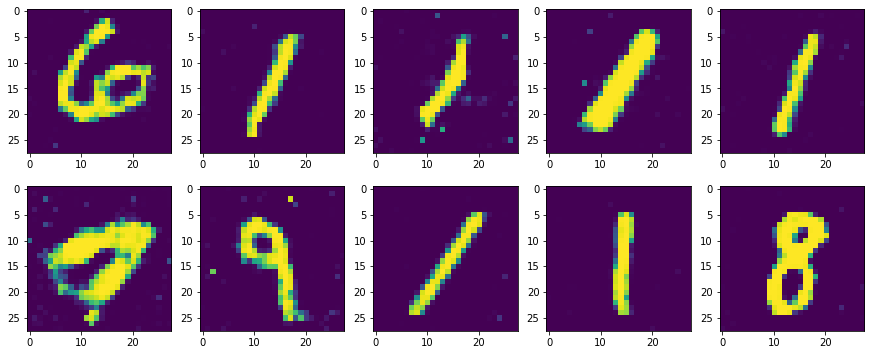

In [13]:
import os
weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/gan/GAN_500'

noise = tf.random.normal([10, 100]) 

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

위와 같이 10개의 결과 이미지는 서로 다른 숫자들이 시각화되었다.  
이러한 방법으로는 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 한다. 원하는 숫자를 바로 얻어내기 위해 cGAN을 사용해보자.

## 8. cGAN으로 MNIST 학습 및 테스트  
이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용한다.


In [14]:
cgan_generator = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent=True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
    
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    return gene_loss, disc_loss

위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습 시켜 보겠다.

In [15]:
EPOCHS = 1
for epoch in range(1, EPOCHS+1):
    
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
    
        if (i+1) % 100 == 0:
            print(f"[{epoch}/{EPOCHS} EPOCHS, {i} ITER] G:{gene_loss}, D:{disc_loss}")

[1/1 EPOCHS, 99 ITER] G:5.468311309814453, D:0.008614793419837952
[1/1 EPOCHS, 199 ITER] G:4.215452194213867, D:0.03137216717004776
[1/1 EPOCHS, 299 ITER] G:2.7057013511657715, D:0.1978956162929535
[1/1 EPOCHS, 399 ITER] G:3.7204761505126953, D:0.07972374558448792


학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없다.  
위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야한다.
시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 사용해보자.

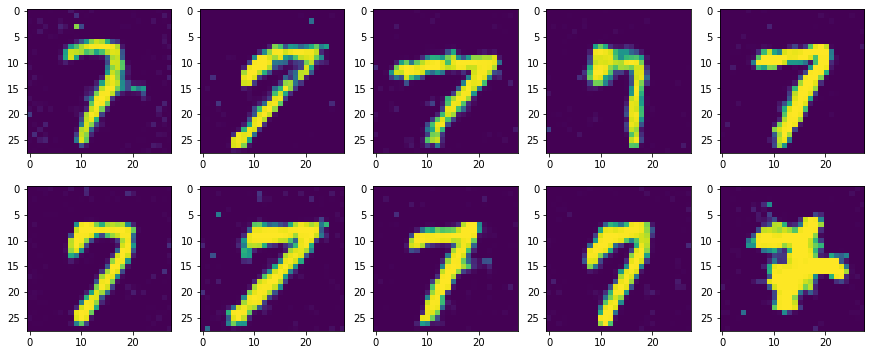

In [16]:
number = 7  # 생성할 숫자 입력

weight_path = os.getenv('HOME')+'/aiffel/conditional_generation/cgan/CGAN_500'

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis=0)
label = tf.repeat(label, 10, axis=0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize=(15,6))
for i in range(1, 11):
    plt.subplot(2,5,i)
    plt.imshow(output[i-1])

number에 입력한 숫자에 해당하는 손글씨가 시각화되었다.